# Assignment 1

Deadline: 19.03.2025, 12:00 CET

Olivier Scokaert, 20-732-095, olivier.scokaert@uzh.ch

In [32]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
#project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
project_root = "/Users/olivierscokaert/Desktop/UZH Master/UZH FS 25/Quantitative_PF_Management_Python/Code"
src_path = os.path.join(project_root, 'qpmwp-course', 'src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [63]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
# mean = <your code here>
mean = np.random.randn(N)
# cov = <your code here>
A = np.random.randn(N, N)
cov = np.dot(A, A.T)

# Generate the Multivariate-Normal random dataset
# data = <your code here>
data = np.random.multivariate_normal(mean, cov, size=T)
print(data.shape)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
# q =  <your code here>
er = ExpectedReturn(method='arithmetic')
q = er.estimate(X=df)
q = er.vector.to_numpy()

# Compute the covariance matrix from df
# P = <your code here>
covar = Covariance()
covar.estimate(X=df)
P = covar.matrix.to_numpy()

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

(1000, 100)
Vector of expected returns (q):
[-0.97047934 -0.26917454  0.16055987 -0.97078478 -1.57887795  0.30804444
 -1.29773109 -0.01994481  0.39485326 -1.02032657  0.0840598   1.45734735
  0.30888385 -0.93993747 -0.25411263 -1.48286448 -1.03296586 -1.61076449
 -0.27538444  0.69519122  0.51090492 -0.37073747  1.23004485  1.03623671
 -2.57055067  0.11402209 -0.18384809  0.19215635  0.63201207 -0.08543504
 -0.12370775  0.710753   -0.33148512 -1.1492252   0.44331615  0.31995847
 -0.02700779 -0.44702898  0.05357106 -0.94069463 -0.55929008 -0.89799574
 -1.85288912 -1.33898414 -0.47497562  0.93024564  0.23308088  0.68819328
  1.26175982  0.46952983  0.55097531 -1.22842047  1.88898222  1.77361476
 -0.87109168  0.91704904  1.45937198  1.18828035  2.02938367 -0.9408961
  0.88189477  0.17757816  0.73968768  0.40115966 -0.74266907  1.40456631
 -1.54267083 -0.83194601  2.43063772  0.52039974 -1.80032986  0.62375352
 -0.81087147 -0.93444081 -0.13462127 -0.02689591  2.05125477 -0.1567363
  0.40217

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [43]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense="=")

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2)

# Add linear constraints
G = pd.DataFrame(0, index=['Group1', 'Group2', 'Group3'], columns=range(1, N+1))
G.loc['Group1', 1:30] = 1
G.loc['Group2', 31:60] = 1
G.loc['Group3', 61:100] = 1 
constraints.add_linear(
    G=G,
    sense=pd.Series(['<=', '<=', '<='], index=G.index),
    rhs=pd.Series([0.3, 0.4, 0.5], index=G.index),
    name="group_constraint_1"
)

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [62]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results
solutions_dct = dict()
for solver in USABLE_SOLVERS:
    qp = QuadraticProgram(P=P, q=q, G=GhAb["G"].astype(np.float64), h=GhAb["h"], A=GhAb["A"], b=GhAb["b"], solver=solver)
    qp.solve()
    solutions_dct[solver] = qp.results["solution"]

Print and visualize the results

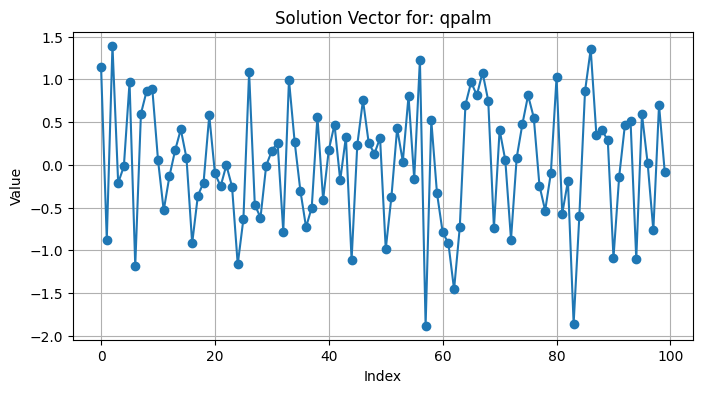

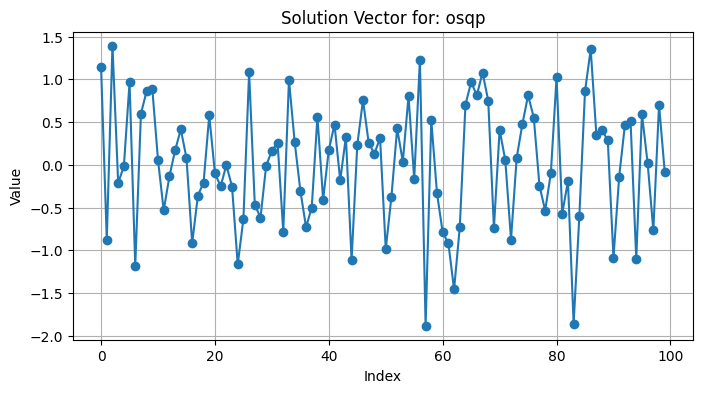

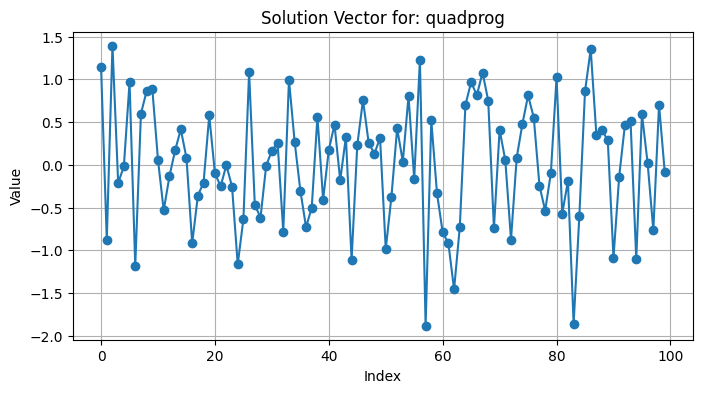

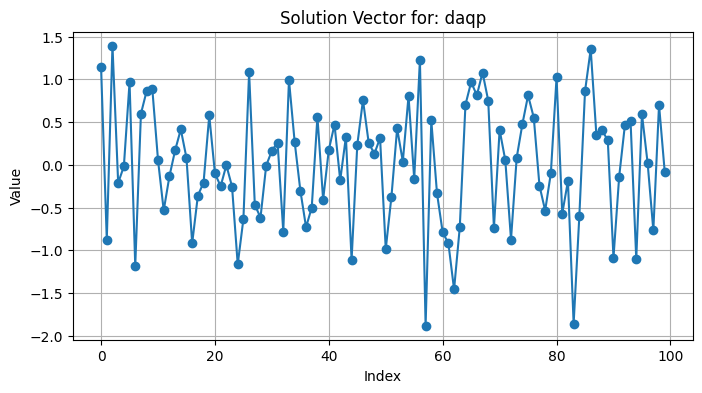

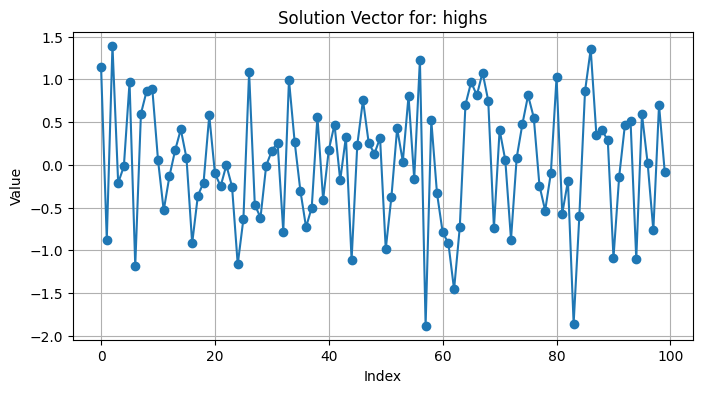

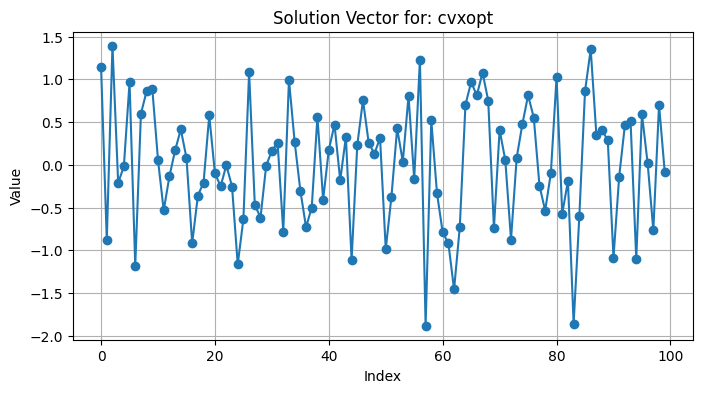

In [64]:
for solver_key, solver_solution in solutions_dct.items():
    #print(solver_solution)
    plt.figure(figsize=(8, 4))
    plt.plot(solver_solution.x, marker='o', linestyle='-')
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Solution Vector for: {solver_key}")
    plt.grid()
    plt.show()
    print("\n")

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [ ]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        self.objective = Objective(
            P = covmat * 2 * self.params['risk_aversion'], # needs to be checked
        )
        return None

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            #<your code here>
            return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
constraints_mv = Constraints(ids = df.columns.tolist())
constraints_mv.add_budget(rhs=1, sense="=")

# Instantiate the MinVariance class
mv = MinVariance(constraints=constraints_mv, covariance=P, solver_name="analytical")

# Prepare the optimization data and prepare the optimization problem
opti_data = OptimizationData(P=P, q=q)

# Solve the optimization problem and print the weights
mv.set_objective(optimization_data=opti_data)
analytical_solution = mv.solve()
print(analytical_solution["weights"])